In [1]:
import nltk
import numpy as np
import pandas as pd
import string
import re 
import time 
from collections import Counter
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import calendar
from sklearn.preprocessing import MinMaxScaler 
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier


In [2]:
orig_bets_encrypted = pd.read_csv('bets_encrypted_clnd.csv')
orig_tag_changes = pd.read_csv('tag_changes_clnd.csv')

bets_encrypted = orig_bets_encrypted.copy()
tag_changes = orig_tag_changes.copy()

# MERGING DATAFRAMES
##### Merging on encrypted_user_no, entries before any valid insert_date are assigned a value of one.

In [3]:
print(bets_encrypted['hours_to_event'].min())
print(bets_encrypted['hours_to_event'][bets_encrypted['hours_to_event']<0].nunique())

-480.20638888888885
2666


In [4]:
# merging so that riskexposure is filled based on timestamp of bet

copy_tag_changes = orig_tag_changes.copy()
copy_bets_encrypted = orig_bets_encrypted.copy()

# Convert date columns to datetime format
copy_bets_encrypted['betTimestamp'] = pd.to_datetime(copy_bets_encrypted['betTimestamp'])
copy_tag_changes['insert_date'] = pd.to_datetime(copy_tag_changes['insert_date'])

# Sort dataframes by respective timestamp columns
copy_bets_encrypted = copy_bets_encrypted.sort_values(['betTimestamp'])
copy_tag_changes = copy_tag_changes.sort_values(['insert_date'])

# Filter copy_bets_encrypted to only include rows that have a encrypted_user_no in copy_tag_changes
copy_bets_encrypted = copy_bets_encrypted[copy_bets_encrypted['encrypted_user_no'].isin(copy_tag_changes['encrypted_user_no'])]

# Only merge if betTimestamp >= insert_date, otherwise all entries before first insert_date are assigned 1
merged_df = pd.merge_asof(copy_bets_encrypted, 
                          copy_tag_changes[['insert_date', 'encrypted_user_no', 'riskexposureprematch']],
                          left_on='betTimestamp', 
                          right_on='insert_date', 
                          by='encrypted_user_no', 
                          direction='backward')

def adjust_values(df):
    df['riskexposureprematch'] = df['riskexposureprematch'].ffill()
    df['riskexposureprematch'].fillna(1, inplace=True)
    return df

merged_df = merged_df.groupby('encrypted_user_no').apply(adjust_values)

/var/folders/yz/86sy0w0519d250z0rfq2qx5w0000gp/T/ipykernel_39209/1058456154.py:30: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  merged_df = merged_df.groupby('encrypted_user_no').apply(adjust_values)


In [5]:
merged_df.columns

Index(['betTimestamp', 'odds_units', 'stake_gbp', 'count_legs',
       'hours_to_event', 'betDate', 'edge', 'encrypted_user_no', 'insert_date',
       'riskexposureprematch'],
      dtype='object')

In [6]:
merged_df.shape

(2635574, 10)

In [7]:
### Remove duplicated bets with two riskexposureprematch lower than it

# Sort the dataframe by 'encrypted_user_no', 'betTimestamp', and 'insert_date' in descending order
merged_df = merged_df.sort_values(by=['encrypted_user_no', 'betTimestamp', 'insert_date'], ascending=[True, False, False])

# Drop duplicate rows keeping the first occurrence (latest 'riskexposureprematch' according to 'insert_date' for each bet)
merged_df = merged_df.drop_duplicates(subset=['encrypted_user_no', 'odds_units', 'stake_gbp', 'count_legs',
       'hours_to_event', 'betDate', 'edge'], keep='first')

In [8]:
# drop duplicates
merged_df = merged_df.drop_duplicates()

In [9]:
merged_df.shape

(2479352, 10)

In [10]:
merged_df.dtypes

betTimestamp            datetime64[ns]
odds_units                     float64
stake_gbp                      float64
count_legs                       int64
hours_to_event                 float64
betDate                         object
edge                           float64
encrypted_user_no               object
insert_date             datetime64[ns]
riskexposureprematch           float64
dtype: object

In [11]:
### Get difference between bets sequentially

cols_to_diff = ['betTimestamp', 'odds_units', 'stake_gbp', 'count_legs',
       'hours_to_event', 'riskexposureprematch']  

for col in cols_to_diff:
    merged_df[col + '_diff'] = merged_df.groupby('encrypted_user_no')[col].diff()

merged_df['betTimestamp_diff'] = merged_df['betTimestamp_diff'].fillna(pd.Timedelta(seconds=0))
merged_df['betTimestamp_diff'] = merged_df['betTimestamp_diff'].dt.total_seconds()

In [12]:
merged_df.dtypes

betTimestamp                 datetime64[ns]
odds_units                          float64
stake_gbp                           float64
count_legs                            int64
hours_to_event                      float64
betDate                              object
edge                                float64
encrypted_user_no                    object
insert_date                  datetime64[ns]
riskexposureprematch                float64
betTimestamp_diff                   float64
odds_units_diff                     float64
stake_gbp_diff                      float64
count_legs_diff                     float64
hours_to_event_diff                 float64
riskexposureprematch_diff           float64
dtype: object

In [13]:
merged_df.drop_duplicates(inplace=True)

In [14]:

# sort by user and betTimestamp
merged_df = merged_df.sort_values(by=['encrypted_user_no', 'betTimestamp'])

### Adding total bet count
merged_df['total_bets'] = merged_df.groupby('encrypted_user_no')['betTimestamp'].transform('count')

### Adding avg riskexposureprematch
merged_df['avg_riskexposureprematch'] = merged_df.groupby('encrypted_user_no')['riskexposureprematch'].transform('mean')

### Adding avg odds_units
merged_df['avg_odds_units'] = merged_df.groupby('encrypted_user_no')['odds_units'].transform('mean')

### Adding avg stake_gbp
merged_df['avg_stake_gbp'] = merged_df.groupby('encrypted_user_no')['stake_gbp'].transform('mean')

### Adding total stake_gbp
merged_df['total_stake_gbp'] = merged_df.groupby('encrypted_user_no')['stake_gbp'].transform('sum')

### Adding month, day, hour and day of week
merged_df['month'] = merged_df['betTimestamp'].dt.month
merged_df['day'] = merged_df['betTimestamp'].dt.day
merged_df['day_of_week'] = merged_df['betTimestamp'].dt.dayofweek
merged_df['hour'] = merged_df['betTimestamp'].dt.hour

In [15]:
### Add num bets before change in riskexposureprematch

# Sort DataFrame
merged_df = merged_df.sort_values(by=['encrypted_user_no', 'betTimestamp'])

# Define a function to return series of counts that resets when riskexposureprematch changes
def count_reset(df):
    df['bet_sequence_count'] = (df['riskexposureprematch'] != df['riskexposureprematch'].shift()).cumsum()
    return df

# Apply the function to each user's data
merged_df = merged_df.groupby('encrypted_user_no').apply(count_reset)

# Now, 'bet_count_before_risk_change' marks each separate "run" of unchanging riskexposureprematch per user.
# We want to transform that into the size of the group it identifies:
merged_df['total_bets_in_sequence'] = merged_df.groupby(['encrypted_user_no', 'bet_sequence_count']).transform('size')

# Instead of transform('size'), we will use cumcount() + 1 (as cumcount starts at 0) to get running count of bets
merged_df['bet_sequence_count'] = merged_df.groupby(['encrypted_user_no', 'total_bets_in_sequence']).cumcount() + 1


/var/folders/yz/86sy0w0519d250z0rfq2qx5w0000gp/T/ipykernel_39209/1190811371.py:12: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  merged_df = merged_df.groupby('encrypted_user_no').apply(count_reset)


In [16]:
merged_df = merged_df.sort_values(by=['encrypted_user_no', 'betTimestamp'])

### Adding total bet count up until that bet
merged_df['total_bets_until_now'] = merged_df.groupby('encrypted_user_no').cumcount() + 1

### Adding avg riskexposureprematch up until that bet
merged_df['avg_riskexposureprematch_until_now'] = merged_df.groupby('encrypted_user_no')['riskexposureprematch'].expanding().mean().reset_index(level=0, drop=True)

### Adding avg odds_units up until that bet
merged_df['avg_odds_units_until_now'] = merged_df.groupby('encrypted_user_no')['odds_units'].expanding().mean().reset_index(level=0, drop=True)

### Adding avg count_legs up until that bet
merged_df['avg_count_legs_until_now'] = merged_df.groupby('encrypted_user_no')['count_legs'].expanding().mean().reset_index(level=0, drop=True)

### Adding avg stake_gbp up until that bet
merged_df['avg_stake_gbp_until_now'] = merged_df.groupby('encrypted_user_no')['stake_gbp'].expanding().mean().reset_index(level=0, drop=True)

### Adding total stake_gbp up until that bet
merged_df['total_stake_gbp_until_now'] = merged_df.groupby('encrypted_user_no')['stake_gbp'].cumsum()


In [17]:
### Adding standard deviation of each sequence
# Sort the DataFrame by 'encrypted_user_no', 'betTimestamp', and 'insert_date'
merged_df = merged_df.sort_values(by=['encrypted_user_no', 'betTimestamp', 'insert_date'])

# Create a new column to store the standard deviation
merged_df['std_stake_gbp_until_now'] = np.nan

# Define a function to calculate the standard deviation for each user until that point in time
def calculate_std(df):
    if len(df) > 1:
        std = df['stake_gbp'].std()
        df['std_stake_gbp_until_now'] = std
    return df

# Apply the function to each user's data until that point in time (grouped by 'encrypted_user_no')
merged_df = merged_df.groupby('encrypted_user_no').apply(calculate_std)


/var/folders/yz/86sy0w0519d250z0rfq2qx5w0000gp/T/ipykernel_39209/2378219878.py:16: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  merged_df = merged_df.groupby('encrypted_user_no').apply(calculate_std)


In [18]:
### Add number of bets in last 1/2/3/4 weeks
merged_df = merged_df.sort_values(by=['encrypted_user_no', 'betTimestamp'])

# Ensure betTimestamp is in datetime format
merged_df['betTimestamp'] = pd.to_datetime(merged_df['betTimestamp'])

# Sort by 'encrypted_user_no' and 'betTimestamp'
merged_df.sort_values(by=['encrypted_user_no', 'betTimestamp'], inplace=True)

# Convert the 'betTimestamp' to the index
merged_df.set_index('betTimestamp', inplace=True)

# Define the time periods
weeks = [1, 2, 3, 4]

# For each time period, calculate the rolling count of bets for each user
for week in weeks:
    merged_df[f'bets_in_last_{week}_week(s)'] = (merged_df.groupby('encrypted_user_no')['total_bets']
                                                 .rolling(f'{week*7}D').count().values)

# Reset the index
merged_df.reset_index(inplace=True)

In [19]:
### Add number of sequences of bets with same riskexposureprematch

# Sort the dataframe by 'encrypted_user_no' and 'betTimestamp'
merged_df.sort_values(by=['encrypted_user_no', 'betTimestamp'])

# Group the dataframe by 'encrypted_user_no'
grouped = merged_df.groupby('encrypted_user_no')

# Calculate the cumulative sum of changes in 'riskexposureprematch' for each group
change_count = (grouped['riskexposureprematch'].shift() != merged_df['riskexposureprematch']).cumsum()

# Assign the calculated change count to the 'riskexposure_change_count' column
merged_df['num_sequences_until_now'] = change_count

In [20]:
### Adding total bets in previous sequence

# Sort the DataFrame by 'encrypted_user_no' and 'betTimestamp'
merged_df = merged_df.sort_values(by=['encrypted_user_no', 'betTimestamp'])

# Identify the rows where 'riskexposureprematch' changes
risk_exposure_changes = merged_df['riskexposureprematch'].ne(merged_df['riskexposureprematch'].shift())

# Calculate the total bets in the previous sequence using cumulative sum
merged_df['num_bets_in_prev_sequence'] = merged_df['total_bets_until_now'].where(risk_exposure_changes).groupby(merged_df['encrypted_user_no']).ffill()

# Fill the remaining NaN values with 0
merged_df['num_bets_in_prev_sequence'].fillna(0, inplace=True)

In [21]:
### Add time difference between changes in riskexposureprematch

# Sort the DataFrame by 'encrypted_user_no' and 'insert_date'
merged_df = merged_df.sort_values(by=['encrypted_user_no', 'betTimestamp', 'insert_date'])

# Identify the rows where 'riskexposureprematch' changes
risk_exposure_changes = merged_df['riskexposureprematch'].ne(merged_df['riskexposureprematch'].shift())

# Create a new column to store the 'insert_date' of different 'riskexposureprematch' values
merged_df['risk_change_insert_date'] = merged_df['insert_date'].where(risk_exposure_changes)

# Forward-fill the 'risk_change_insert_date' values within each 'encrypted_user_no' group
merged_df['risk_change_insert_date'] = merged_df.groupby('encrypted_user_no')['risk_change_insert_date'].ffill()

# Calculate the time differences in hours between the 'insert_date' and 'risk_change_insert_date'
merged_df['time_diff_of_riskexposure'] = (merged_df['insert_date'] - merged_df['risk_change_insert_date']).dt.total_seconds().fillna(0)

# Drop the 'risk_change_insert_date' column if not needed anymore
merged_df.drop('risk_change_insert_date', axis=1, inplace=True)


In [22]:
# Keep rows where 'hours_to_event' is more than 0 (4410 are now)
merged_df = merged_df[merged_df['hours_to_event']>0]

In [23]:
print(merged_df.columns)
print(merged_df.shape)

Index(['betTimestamp', 'odds_units', 'stake_gbp', 'count_legs',
       'hours_to_event', 'betDate', 'edge', 'encrypted_user_no', 'insert_date',
       'riskexposureprematch', 'betTimestamp_diff', 'odds_units_diff',
       'stake_gbp_diff', 'count_legs_diff', 'hours_to_event_diff',
       'riskexposureprematch_diff', 'total_bets', 'avg_riskexposureprematch',
       'avg_odds_units', 'avg_stake_gbp', 'total_stake_gbp', 'month', 'day',
       'day_of_week', 'hour', 'bet_sequence_count', 'total_bets_in_sequence',
       'total_bets_until_now', 'avg_riskexposureprematch_until_now',
       'avg_odds_units_until_now', 'avg_count_legs_until_now',
       'avg_stake_gbp_until_now', 'total_stake_gbp_until_now',
       'std_stake_gbp_until_now', 'bets_in_last_1_week(s)',
       'bets_in_last_2_week(s)', 'bets_in_last_3_week(s)',
       'bets_in_last_4_week(s)', 'num_sequences_until_now',
       'num_bets_in_prev_sequence', 'time_diff_of_riskexposure'],
      dtype='object')
(2476065, 41)


In [24]:
merged_df.drop_duplicates(inplace=True)
merged_df.shape

(2476065, 41)

In [31]:
# There are NaN values in the delta columns since the first bet made by a user will not have any previous bets to
# create a delta from. Hence the value for the delta of the first bet of each user will be set to 0.

# Iterate through the columns, and if the column name ends with '_diff', fill NaN values with 0
# Assuming 'data' is your DataFrame
cols_to_fill = [col for col in merged_df.columns if col.endswith('_diff') or col == 'std_stake_gbp_until_now']

# Fill NaN values with 0 for the specified columns
merged_df[cols_to_fill] = merged_df[cols_to_fill].fillna(0)

In [32]:
# Check that none of the features to be used contain NaN values
cols_with_nan = merged_df.isna().any()
cols_with_nan['encrypted_user_no'] = True
cols_with_nan['insert_date'] = False
nan_cols_df = merged_df.loc[:, cols_with_nan]
rows_with_nan_in_cols = nan_cols_df[nan_cols_df.isna().any(axis=1)]
print(rows_with_nan_in_cols)

Empty DataFrame
Columns: [encrypted_user_no]
Index: []


In [34]:
print(merged_df.shape)
merged_df.head()

(2476065, 41)


,betTimestamp,odds_units,stake_gbp,count_legs,hours_to_event,betDate,edge,encrypted_user_no,insert_date,riskexposureprematch,...,avg_stake_gbp_until_now,total_stake_gbp_until_now,std_stake_gbp_until_now,bets_in_last_1_week(s),bets_in_last_2_week(s),bets_in_last_3_week(s),bets_in_last_4_week(s),num_sequences_until_now,num_bets_in_prev_sequence,time_diff_of_riskexposure
0,2023-01-11 17:42:00,13.35,4.43,7,5.157143,2023-01-11,0.0,"b"" \x88\r!v\xc3\x14\x13\x1dy\x80\xea\x17\xf0'""",NaT,1.00,...,4.430,4.43,4.200098,1.0,1.0,1.0,1.0,1,1.0,0.0
1,2023-01-11 19:54:21,6.40,0.89,1,0.094167,2023-01-11,0.0,"b"" \x88\r!v\xc3\x14\x13\x1dy\x80\xea\x17\xf0'""",2023-01-11 18:25:15,2.99,...,2.660,5.32,4.200098,2.0,2.0,2.0,2.0,2,2.0,0.0
2,2023-01-11 19:54:40,27.00,0.89,1,0.088889,2023-01-11,0.0,"b"" \x88\r!v\xc3\x14\x13\x1dy\x80\xea\x17\xf0'""",2023-01-11 18:25:15,2.99,...,2.070,6.21,4.200098,3.0,3.0,3.0,3.0,2,2.0,0.0
3,2023-01-12 18:23:56,4.87,4.43,4,1.101111,2023-01-12,0.0,"b"" \x88\r!v\xc3\x14\x13\x1dy\x80\xea\x17\xf0'""",2023-01-11 18:25:15,2.99,...,2.660,10.64,4.200098,4.0,4.0,4.0,4.0,2,2.0,0.0
4,2023-01-12 18:30:46,23.07,0.89,3,1.153889,2023-01-12,0.0,"b"" \x88\r!v\xc3\x14\x13\x1dy\x80\xea\x17\xf0'""",2023-01-11 18:25:15,2.99,...,2.306,11.53,4.200098,5.0,5.0,5.0,5.0,2,2.0,0.0


In [33]:
# save merged_df to csv
merged_df.to_csv('merged_df.csv', index=False)

In [2]:
orig_merged_df = pd.read_csv('merged_df.csv')

merged_df = orig_merged_df.copy()

In [3]:
print(merged_df.columns)
print(merged_df.shape)

Index(['betTimestamp', 'odds_units', 'stake_gbp', 'count_legs',
       'hours_to_event', 'betDate', 'edge', 'encrypted_user_no', 'insert_date',
       'riskexposureprematch', 'betTimestamp_diff', 'odds_units_diff',
       'stake_gbp_diff', 'count_legs_diff', 'hours_to_event_diff',
       'riskexposureprematch_diff', 'total_bets', 'avg_riskexposureprematch',
       'avg_odds_units', 'avg_stake_gbp', 'total_stake_gbp', 'month', 'day',
       'day_of_week', 'hour', 'bet_sequence_count', 'total_bets_in_sequence',
       'total_bets_until_now', 'avg_riskexposureprematch_until_now',
       'avg_odds_units_until_now', 'avg_count_legs_until_now',
       'avg_stake_gbp_until_now', 'total_stake_gbp_until_now',
       'std_stake_gbp_until_now', 'bets_in_last_1_week(s)',
       'bets_in_last_2_week(s)', 'bets_in_last_3_week(s)',
       'bets_in_last_4_week(s)', 'num_sequences_until_now',
       'num_bets_in_prev_sequence', 'time_diff_of_riskexposure'],
      dtype='object')
(2476065, 41)


In [28]:
# Assuming you have a DataFrame named 'bets_encrypted' containing the dataset
# Calculate the maximum values for each column
max_values = merged_df.max()

# Calculate the minimum values for each column
min_values = merged_df.min()

# Print the maximum and minimum values for each column
for column in merged_df.columns:
    print(f"Column: {column}")
    print(f"Max Value: {max_values[column]}")
    print(f"Min Value: {min_values[column]}")
    print("-------------------------------")

Column: betTimestamp
Max Value: 2023-05-01 23:59:49
Min Value: 2023-01-01 04:41:06
-------------------------------
Column: odds_units
Max Value: 13084690.27
Min Value: 1.01
-------------------------------
Column: stake_gbp
Max Value: 37407.54
Min Value: 0.0
-------------------------------
Column: count_legs
Max Value: 40
Min Value: 1
-------------------------------
Column: hours_to_event
Max Value: 24287.13027777778
Min Value: 0.0002777777777777
-------------------------------
Column: betDate
Max Value: 2023-05-01
Min Value: 2023-01-01
-------------------------------
Column: edge
Max Value: 71.9672131147541
Min Value: -77.61938702779759
-------------------------------
Column: encrypted_user_no
Max Value: b'~}\xa7(\xb6\x19\xa38E@\xbc\xa5\x9f\xe6x\x0e'
Min Value: b"  \x88\r!v\xc3\x14\x13\x1dy\x80\xea\x17\xf0'"
-------------------------------
Column: insert_date
Max Value: 2023-05-01 16:37:01
Min Value: 2023-01-01 00:04:05
-------------------------------
Column: riskexposureracing
Max Val

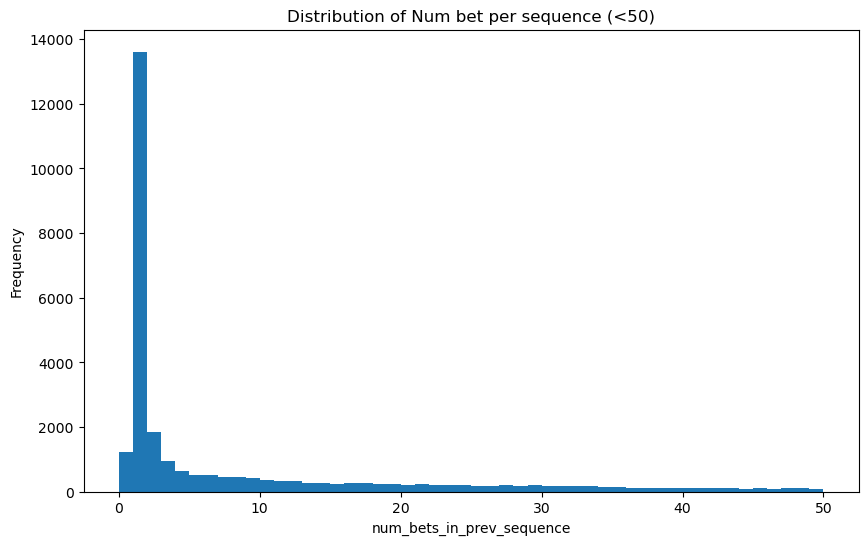

In [29]:
# Group by user, drop duplicates within each group, and reset index
unique_sequences_df = merged_df.groupby('encrypted_user_no').apply(lambda x: x.drop_duplicates(subset='num_bets_in_prev_sequence')).reset_index(drop=True)

# Filter values under 250
filtered_df = unique_sequences_df[unique_sequences_df['num_bets_in_prev_sequence'] < 50]

# Plot histogram for the filtered values
plt.figure(figsize=(10, 6))
filtered_df['num_bets_in_prev_sequence'].hist(bins=50, range=(0,50))
plt.xlabel('num_bets_in_prev_sequence')
plt.ylabel('Frequency')
plt.title('Distribution of Num bet per sequence (<50)')
plt.grid(False)
plt.show()

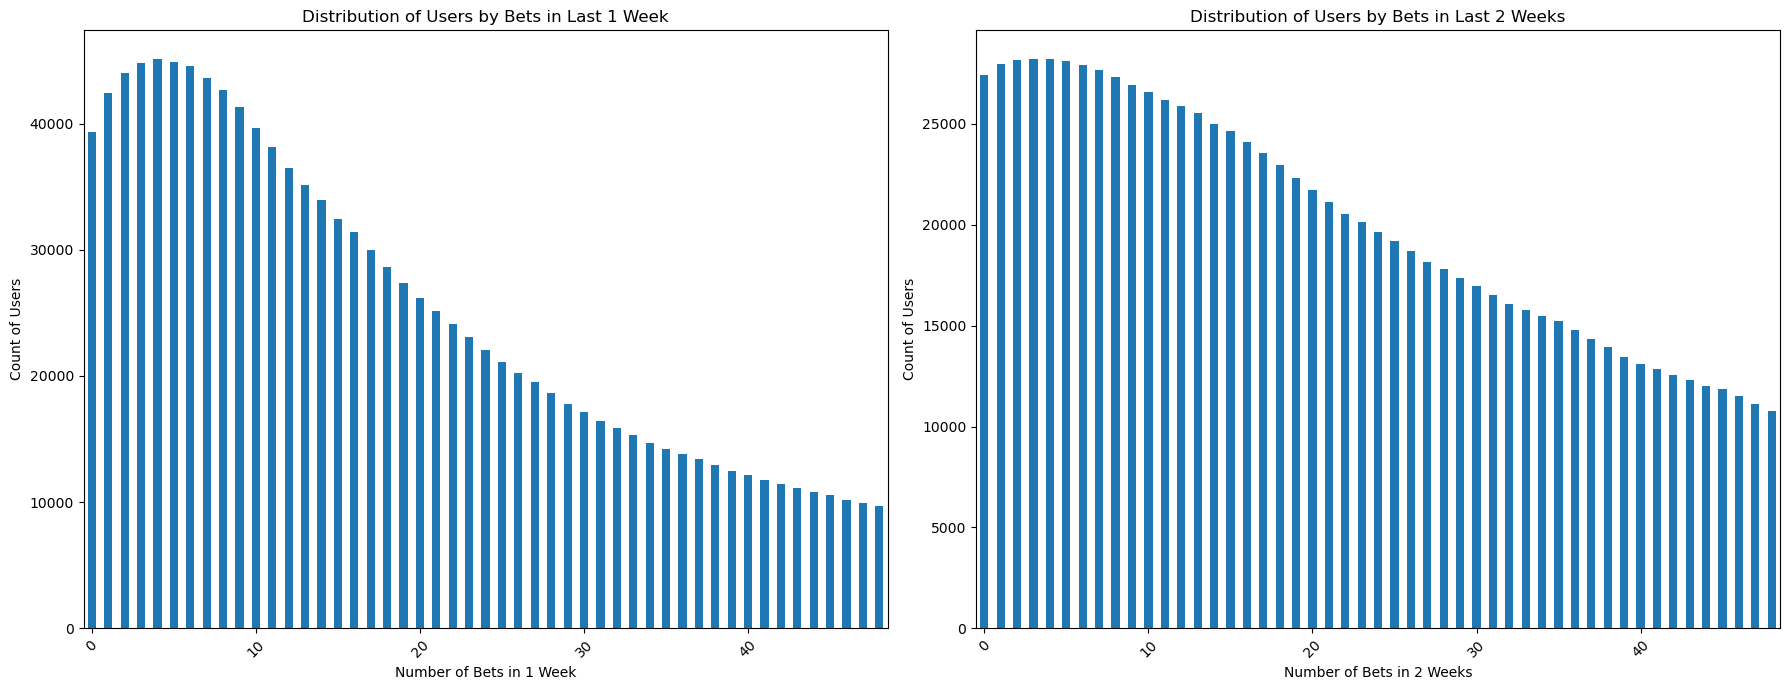

In [26]:
from matplotlib.ticker import FuncFormatter, MaxNLocator

# Formatter function
def format_as_integer(x, _):
    return f"{int(x)}"

# Filter for values under a threshold, for example, 50
threshold = 50
filtered_1_week_counts = merged_df[merged_df['bets_in_last_1_week(s)'] < threshold].groupby('bets_in_last_1_week(s)').size()
filtered_2_week_counts = merged_df[merged_df['bets_in_last_2_week(s)'] < threshold].groupby('bets_in_last_2_week(s)').size()

# Plotting
plt.figure(figsize=(18, 7))

# Plot for 1 week
plt.subplot(1, 2, 1)
filtered_1_week_counts.plot(kind='bar')
plt.xlabel('Number of Bets in 1 Week')
plt.ylabel('Count of Users')
plt.title('Distribution of Users by Bets in Last 1 Week')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
ax1 = plt.gca()
ax1.xaxis.set_major_formatter(FuncFormatter(format_as_integer))  # Format x-axis labels as integers
ax1.xaxis.set_major_locator(MaxNLocator(nbins='auto', integer=True, steps=[5]))  # Set major ticks every 5th value

# Plot for 2 weeks
plt.subplot(1, 2, 2)
filtered_2_week_counts.plot(kind='bar')
plt.xlabel('Number of Bets in 2 Weeks')
plt.ylabel('Count of Users')
plt.title('Distribution of Users by Bets in Last 2 Weeks')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
ax2 = plt.gca()
ax2.xaxis.set_major_formatter(FuncFormatter(format_as_integer))  # Format x-axis labels as integers
ax2.xaxis.set_major_locator(MaxNLocator(nbins='auto', integer=True, steps=[5]))  # Set major ticks every 5th value

plt.tight_layout()
plt.show()


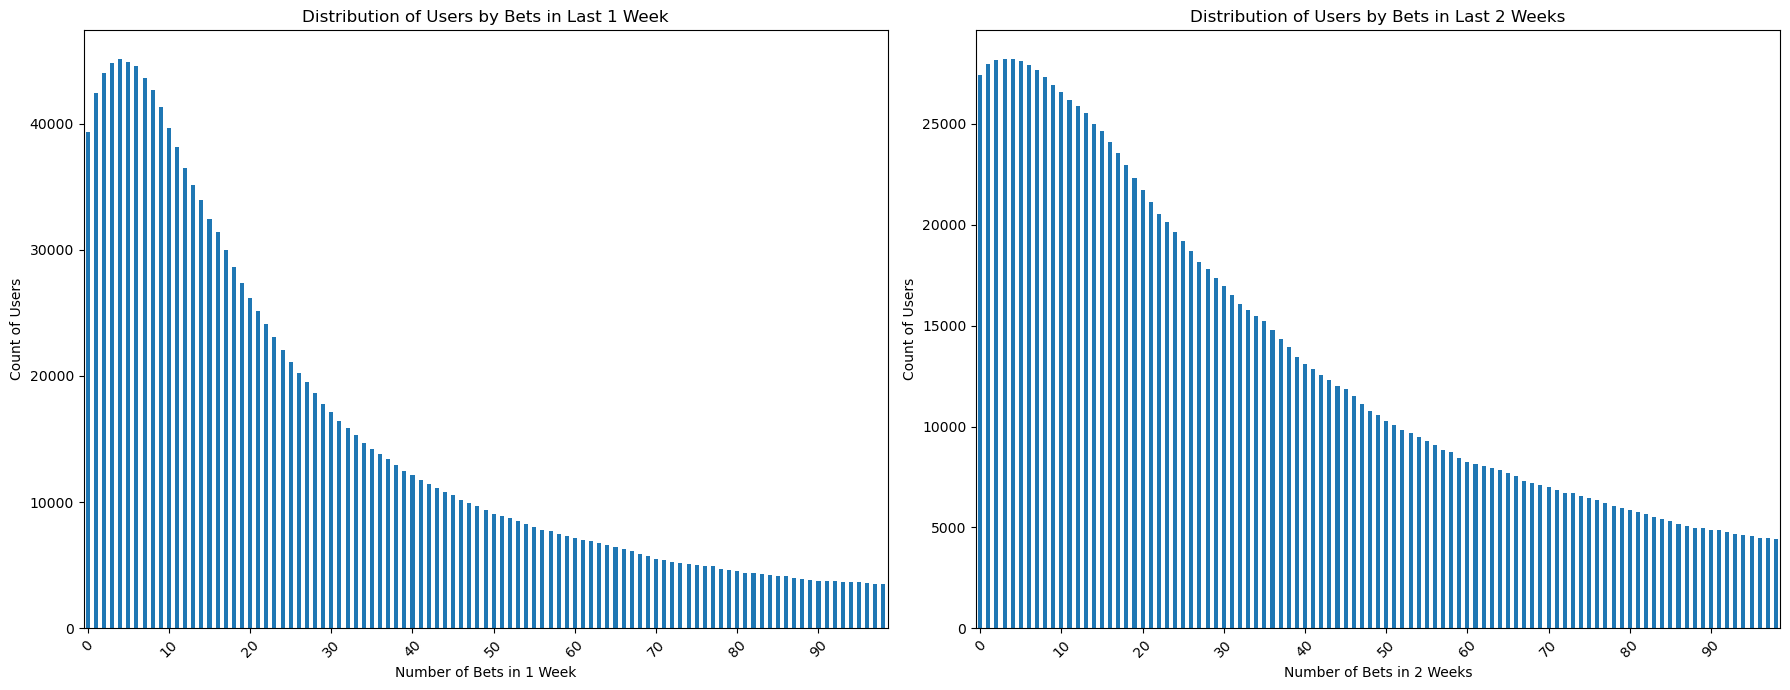

In [28]:
from matplotlib.ticker import FuncFormatter, MaxNLocator

# Formatter function
def format_as_integer(x, _):
    return f"{int(x)}"

# Filter for values under a threshold, for example, 50
threshold = 100
filtered_1_week_counts = merged_df[merged_df['bets_in_last_1_week(s)'] < threshold].groupby('bets_in_last_1_week(s)').size()
filtered_2_week_counts = merged_df[merged_df['bets_in_last_2_week(s)'] < threshold].groupby('bets_in_last_2_week(s)').size()

# Plotting
plt.figure(figsize=(18, 7))

# Plot for 1 week
plt.subplot(1, 2, 1)
filtered_1_week_counts.plot(kind='bar')
plt.xlabel('Number of Bets in 1 Week')
plt.ylabel('Count of Users')
plt.title('Distribution of Users by Bets in Last 1 Week')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
ax1 = plt.gca()
ax1.xaxis.set_major_formatter(FuncFormatter(format_as_integer))  # Format x-axis labels as integers
ax1.xaxis.set_major_locator(MaxNLocator(nbins='auto', integer=True, steps=[10]))  # Set major ticks every 5th value

# Plot for 2 weeks
plt.subplot(1, 2, 2)
filtered_2_week_counts.plot(kind='bar')
plt.xlabel('Number of Bets in 2 Weeks')
plt.ylabel('Count of Users')
plt.title('Distribution of Users by Bets in Last 2 Weeks')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
ax2 = plt.gca()
ax2.xaxis.set_major_formatter(FuncFormatter(format_as_integer))  # Format x-axis labels as integers
ax2.xaxis.set_major_locator(MaxNLocator(nbins='auto', integer=True, steps=[10]))  # Set major ticks every 5th value

plt.tight_layout()
plt.show()


In [15]:
#load the labelled data

labelled_df = pd.read_csv('labelled_df.csv')


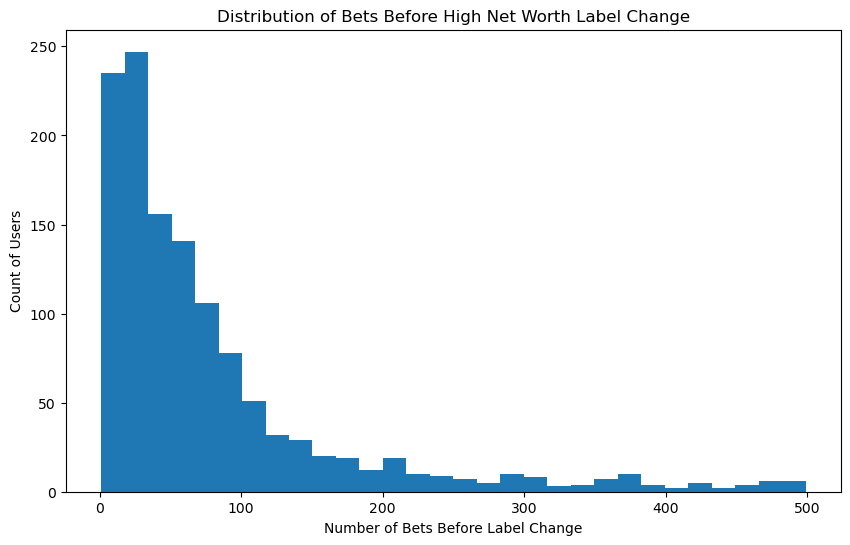

In [18]:

# Detect label changes and sum the rows before the change for each user
def count_bets_before_change(group):
    change_detected = group['high_net_worth'].diff().abs() == 1
    if change_detected.any():
        return change_detected.idxmax() - group.index[0]
    else:
        return None

bets_before_change = labelled_df.groupby('encrypted_user_no').apply(count_bets_before_change).dropna()

# Filter values under 2500
filtered_bets = bets_before_change[bets_before_change < 500]

# Plotting
plt.figure(figsize=(10, 6))
filtered_bets.hist(bins=30)
plt.xlabel('Number of Bets Before Label Change')
plt.ylabel('Count of Users')
plt.title('Distribution of Bets Before High Net Worth Label Change')
plt.grid(False)
plt.show()


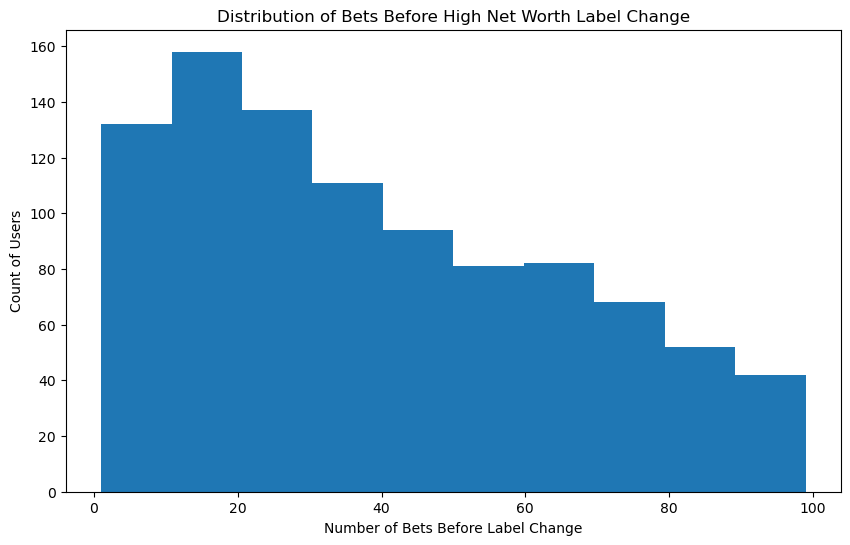

In [30]:

# Detect label changes and sum the rows before the change for each user
def count_bets_before_change(group):
    change_detected = group['high_net_worth'].diff().abs() == 1
    if change_detected.any():
        return change_detected.idxmax() - group.index[0]
    else:
        return None

bets_before_change = labelled_df.groupby('encrypted_user_no').apply(count_bets_before_change).dropna()

# Filter values under 2500
filtered_bets = bets_before_change[bets_before_change < 100]

# Plotting
plt.figure(figsize=(10, 6))
filtered_bets.hist(bins=10)
plt.xlabel('Number of Bets Before Label Change')
plt.ylabel('Count of Users')
plt.title('Distribution of Bets Before High Net Worth Label Change')
plt.grid(False)
plt.show()
